In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
excel_file = pd.read_excel('dataset_clean_semarang_float_AD.xlsx')

In [3]:
df = pd.DataFrame(excel_file)
print(df)


            Date  Time  PM25  PM10
0     2023-09-18     0  23.0  26.0
1     2023-09-18     1  28.5  31.5
2     2023-09-18     2  26.0  29.0
3     2023-09-18     3  18.0  20.0
4     2023-09-18     4  18.0  20.0
...          ...   ...   ...   ...
2083  2023-12-13    19  35.0  39.0
2084  2023-12-13    20  33.0  37.0
2085  2023-12-13    21  40.0  45.0
2086  2023-12-13    22  29.5  33.5
2087  2023-12-13    23  33.0  37.0

[2088 rows x 4 columns]


In [4]:
# memisahkan fitur input dan output
input_features = ['PM25','PM10']
output_features = ['PM25','PM10']

In [5]:
# x mengambil data pada df yang fiturnya ada di input_features
# y mengambil data pada df yang fiturnya ada di output_features
x = df[input_features].values
y = df[output_features].values

In [6]:
print(x)

[[23.  26. ]
 [28.5 31.5]
 [26.  29. ]
 ...
 [40.  45. ]
 [29.5 33.5]
 [33.  37. ]]


In [7]:
# normalisasi supaya skalanya konsisten 0-1
# inisialisasi dulu
scaler = MinMaxScaler()

# x_scaled dan y_scaled ini adalah hasil tranformasi
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

In [8]:
print(x_scaled)

[[0.29310345 0.29411765]
 [0.38793103 0.375     ]
 [0.34482759 0.33823529]
 ...
 [0.5862069  0.57352941]
 [0.40517241 0.40441176]
 [0.46551724 0.45588235]]


In [9]:
print(y_scaled)

[[0.29310345 0.29411765]
 [0.38793103 0.375     ]
 [0.34482759 0.33823529]
 ...
 [0.5862069  0.57352941]
 [0.40517241 0.40441176]
 [0.46551724 0.45588235]]


In [10]:
# Pemisahan data uji, data latih

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, shuffle=False)
# size disini sebagai berapa banyak data yang akan kita gunakan sebagai data testing
# 0.2 artinya 20% data akan digunakan sebagai data uji dan 80% sebagai data latih
# karena kita menggunakan data time series, maka harus ditambahakan shuffle sbg mencegah terjadinya pengacakan data
# saat kita membagi data menjadi data uji dan data latih, urutannya tidak akan teracak


In [11]:
# timesteps ini adalah panjangnya rentang waktu yang akan digunakan input model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

timesteps = 24
# menggunakan data 72 jam sebelumnya menjadi input LSTM

n_features_input = len(input_features)
n_features_output = len(output_features)

In [12]:
# mendefinisikan fungsi
def create_sequences(x, y, time_steps) :
  x_seq, y_seq = [], []

# sebelum mengembalikan nilai para seq, kita akan melakukan iterasi
  for i in range(len(x)-time_steps) : #pengurangan dg timesteps krn data paling terakhir tidak akan bisa di proses
    x_seq.append(x[i : i + time_steps])
    y_seq.append(y[i + time_steps ])

  return np.array(x_seq), np.array(y_seq)

In [13]:
x_train_seq, y_train_seq = create_sequences(x_train, y_train, timesteps)

# test data
x_test_seq, y_test_seq = create_sequences(x_test, y_test, timesteps)

In [14]:
# MODEL LSTM4
model = Sequential()

model.add(LSTM(120, input_shape=(timesteps, n_features_input), return_sequences=True))
model.add(LSTM(120, return_sequences=True))  # Layer LSTM tambahan
model.add(LSTM(120))  # Layer LSTM lainnya
model.add(Dense(n_features_output))

#layer output
model.add(Dense(n_features_output))

In [15]:
model.compile(optimizer='adam', loss='mae') # mae bisa ganti rmse atau mse

In [16]:
#fitting, bangun model
hist = model.fit(x_train_seq, y_train_seq, epochs=100, batch_size=30, validation_data=(x_test_seq, y_test_seq), callbacks=[early_stopping])

Epoch 1/100

55/55 [==============================] - 9s 61ms/step - loss: 0.1863 - val_loss: 0.1469
Epoch 2/100
55/55 [==============================] - 2s 39ms/step - loss: 0.1612 - val_loss: 0.1315
Epoch 3/100
55/55 [==============================] - 2s 40ms/step - loss: 0.1490 - val_loss: 0.1151
Epoch 4/100
55/55 [==============================] - 2s 42ms/step - loss: 0.1270 - val_loss: 0.1001
Epoch 5/100
55/55 [==============================] - 3s 51ms/step - loss: 0.1082 - val_loss: 0.0882
Epoch 6/100
55/55 [==============================] - 3s 52ms/step - loss: 0.0896 - val_loss: 0.0837
Epoch 7/100
55/55 [==============================] - 3s 51ms/step - loss: 0.0857 - val_loss: 0.0857
Epoch 8/100
55/55 [==============================] - 2s 44ms/step - loss: 0.0845 - val_loss: 0.0828
Epoch 9/100
55/55 [==============================] - 2s 41ms/step - loss: 0.0844 - val_loss: 0.0823
Epoch 10/100
55/55 [==============================] - 2s 40ms/step - loss: 0.0846 - val_loss: 0.086

[0.18629395961761475, 0.16117174923419952, 0.14896133542060852, 0.12696439027786255, 0.10817820578813553, 0.08964579552412033, 0.0856628492474556, 0.08452158421278, 0.08435314148664474, 0.08461738377809525, 0.08528004586696625, 0.08257213234901428, 0.0842519998550415, 0.08303004503250122, 0.08456577360630035, 0.08190463483333588, 0.08114590495824814, 0.08303855359554291, 0.08268076926469803, 0.08328546583652496, 0.0837232917547226, 0.08043942600488663, 0.08194152265787125]


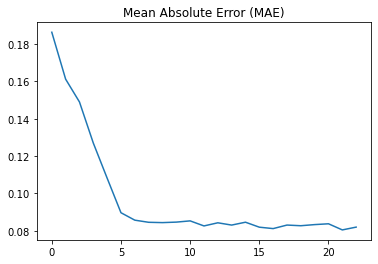

In [17]:
model_history = hist.history
loss = model_history['loss']
print(loss)



plt.figure()
plt.plot(loss, label='MAE')
plt.title('Mean Absolute Error (MAE)')
plt.show()

In [18]:
predictions = model.predict(x_test_seq)

13/13 [==============================] - 1s 14ms/step


In [19]:
# mengembalikan data prediksi ke semula
predictions = scaler.inverse_transform(predictions)

In [20]:
# mengembalikan nilai y_test
y_test_original = scaler.inverse_transform(y_test_seq)

In [21]:
# menghitung MAE prediksi atau mean absolute eror dari testing
mae = np.mean(np.abs(predictions-y_test_original), axis=0)

In [22]:
# iterasi untuk menampilkan MAE masing-masing fitur
for i, feature in enumerate(output_features):
  print("MAE untuk fitur ", feature, " : ", mae[i])

MAE untuk fitur  PM25  :  4.73907990625062
MAE untuk fitur  PM10  :  5.507436716011938


In [23]:
# menentukan batas, modelnya akurat atau tidak
threshold_mae_PM25 = (df['PM25'].max() - df['PM25'].min()) * 10 / 100
print("threshold_mae_PM25 : ", threshold_mae_PM25)

threshold_mae_PM10 = (df['PM10'].max() - df['PM10'].min()) * 10 / 100
print("threshold_mae_PM10 : ", threshold_mae_PM10)


threshold_mae_PM25 :  5.8
threshold_mae_PM10 :  6.8


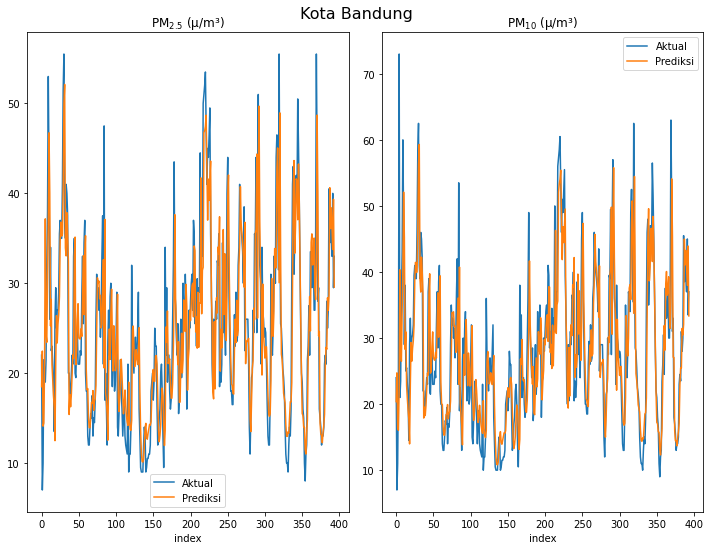

In [24]:
# Create subplots with a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Plot each graph in the specified subplot
axs[0].plot(y_test_original[:, 0], label='Aktual')
axs[0].plot(predictions[:, 0], label='Prediksi')
axs[0].set_xlabel('index')
axs[0].set_title('PM$_{2.5}$ (\u03BC/m\u00B3)')

axs[1].plot(y_test_original[:, 1], label='Aktual')
axs[1].plot(predictions[:, 1], label='Prediksi')
axs[1].set_xlabel('index')
axs[1].set_title('PM$_{10}$ (\u03BC/m\u00B3)')

# Add legends to each subplot
axs[0].legend()
axs[1].legend()

# Add a main title
plt.suptitle('Kota Bandung', fontsize=16, y=0.95)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('AQI_kota_Bandung_plot.jpg')

# Show the combined plot
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

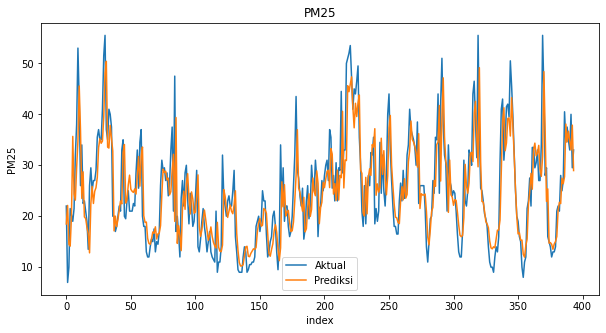

In [25]:
# Plot untuk PM25

target_index = 0 #PM25

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('PM25')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

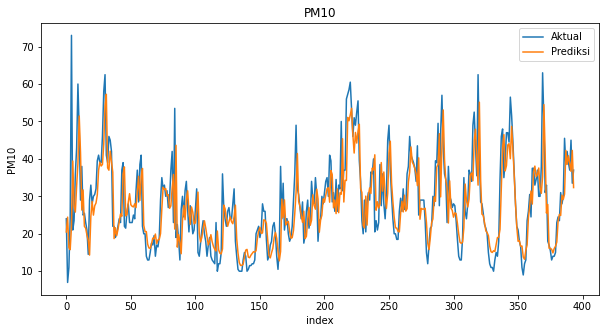

In [26]:
# Plot untuk PM10

target_index = 1 #PM10

plt.figure(figsize=(10,5))
plt.plot(y_test_original[:, target_index], label='Aktual')
plt.plot(predictions[:,target_index], label='Prediksi')
plt.xlabel('index')
plt.ylabel(output_features[target_index])
plt.title('PM10')
plt.legend()
plt.show

In [27]:
# Ambil 24 waktu terakhir dari data Anda
last_24_timesteps = df[input_features].values[-timesteps:]

# Normalisasi menggunakan scaler
last_24_timesteps_scaled = scaler.transform(last_24_timesteps)

# Inisialisasi array untuk menyimpan hasil prediksi
future_predictions = []

# Lakukan prediksi untuk 24 waktu ke depan
for _ in range(72):
    # Reshape untuk sesuai dengan input model
    input_sequence = last_24_timesteps_scaled.reshape(1, timesteps, n_features_input)
    
    # Prediksi satu waktu ke depan
    prediction = model.predict(input_sequence)
    
    # Invers transformasi scaler untuk mendapatkan nilai dalam skala asli
    prediction_inversed = scaler.inverse_transform(prediction)
    
    # Tambahkan prediksi ke dalam array hasil
    future_predictions.append(prediction_inversed.flatten())
    
    # Update sekuens input untuk waktu berikutnya
    last_24_timesteps_scaled = np.concatenate((last_24_timesteps_scaled[1:], prediction), axis=0)

# Konversi hasil prediksi ke dalam DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=output_features)

# Tampilkan hasil prediksi
print(future_predictions_df)

1/1 [==============================] - 0s 31ms/step
         PM25       PM10
0   29.816328  33.081932
1   25.972170  28.789673
2   22.505329  24.850374
3   19.704365  21.651661
4   17.987766  19.725178
..        ...        ...
67  22.111046  24.463480
68  21.872337  24.200754
69  21.560085  23.855444
70  21.198187  23.454313
71  20.814785  23.029011

[72 rows x 2 columns]


In [28]:
P_PM25 = []
P_PM10 = []
for i in future_predictions_df['PM25']:
    P_PM25.append(i)
for i in future_predictions_df['PM10']:
    P_PM10.append(i)

In [29]:
def Perhitungan_Median(PM25, PM10):
    # Median hari ke satu setiap variabel
    m_PM25_1 = np.median(PM25[0:23])
    m_PM10_1 = np.median(PM10[0:23])

    # Median hari ke dua setiap variabel
    m_PM25_2 = np.median(PM25[24:47])
    m_PM10_2 = np.median(PM10[24:47])


    # Median hari ke tiga setiap variabel
    m_PM25_3 = np.median(PM25[48:71])
    m_PM10_3 = np.median(PM10[48:71])

    return m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3

In [30]:
m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3 = Perhitungan_Median(P_PM25, P_PM10)

In [31]:
def hitung_AQI_PM25(median_value):
    if 0.0 <= median_value < 12.0:
        return ((50.0 - 0.0) / (12.0 - 0.0)) * (median_value - 0.0) + 0.0
    elif 12.0 <= median_value < 35.4:
        return ((100.0 - 50.0) / (35.4 - 12.00)) * (median_value - 12.00) + 50.0
    elif 35.4 <= median_value < 55.4:
        return ((150.0 - 100.0) / (55.4 - 35.4)) * (median_value - 35.4) + 100.0
    elif 55.4 <= median_value < 150.4:
        return ((200.0 - 150.0) / (150.4 - 55.4)) * (median_value - 55.4) + 150.0
    elif 150.4 <= median_value < 250.4:
        return ((300.0 - 200.0) / (250.4 - 150.4)) * (median_value - 150.4) + 200.0
    elif 250.5 <= median_value < 350.4:
        return ((400.0 - 300.0) / (350.4 - 250.4)) * (median_value - 250.4) + 300.0
    else:
        return ((500.0 - 400.0) / (500.4 - 305.4)) * (median_value - 305.0) + 400.0

def hitung_AQI_PM10(median_value):
    if 0.0 <= median_value < 54.0:
        return ((50.0 - 0.0) / (54.0 - 0.0)) * (median_value - 0.0) + 0.0
    elif 54.0 <= median_value < 154.0:
        return ((100.0 - 50.0) / (154.0 - 54.00)) * (median_value - 54.00) + 50.0
    elif 154.0 <= median_value < 254.0:
        return ((150.0 - 100.0) / (254.0 - 154.0)) * (median_value - 154.0) + 100.0
    elif 254.0 <= median_value < 354.0:
        return ((200.0 - 150.0) / (354.0 - 254.0)) * (median_value - 254.0) + 150.0
    elif 354.0 <= median_value < 424.0:
        return ((300.0 - 200.0) / (424.0 - 354.0)) * (median_value - 354.0) + 200.0
    elif 424.0 <= median_value < 504.0:
        return ((400.0 - 300.0) / (504.0 - 424.0)) * (median_value - 424.0) + 300.0
    else:
        return ((500.0 - 400.0) / (604.0 - 504.0)) * (median_value - 504.0) + 400.00



def Perhitungan_AQI(m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3):
    AQI_PM25_1 = hitung_AQI_PM25(m_PM25_1)
    AQI_PM25_2 = hitung_AQI_PM25(m_PM25_2)
    AQI_PM25_3 = hitung_AQI_PM25(m_PM25_3)
    AQI_PM10_1 = hitung_AQI_PM10(m_PM10_1)
    AQI_PM10_2 = hitung_AQI_PM10(m_PM10_2)
    AQI_PM10_3 = hitung_AQI_PM10(m_PM10_3)
    
    return AQI_PM25_1, AQI_PM25_2, AQI_PM25_3, AQI_PM10_1, AQI_PM10_2, AQI_PM10_3


In [32]:
AQI_PM25_1, AQI_PM25_2, AQI_PM25_3, AQI_PM10_1, AQI_PM10_2, AQI_PM10_3 = Perhitungan_AQI(m_PM25_1, m_PM10_1, m_PM25_2, m_PM10_2,m_PM25_3, m_PM10_3)

In [33]:
print(round(AQI_PM25_1))
print(round(AQI_PM25_2))
print(round(AQI_PM25_3))
print(round(AQI_PM10_1))
print(round(AQI_PM10_2))
print(round(AQI_PM10_3))

77
73
70
25
23
22
